![train](http://cliparting.com/wp-content/uploads/2016/06/Train-clipart-for-kids-free-free-clipart-images.gif)

In [12]:
import numpy as np
np.random.seed(1019)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import xgboost

import sklearn
from sklearn.model_selection import train_test_split 

import sys, os, gc, types
import time
from subprocess import check_output

In [13]:
sys.path.append('./utils')

from training import cv, train
from plotting import plot_importance
from data import Data

In [14]:
root_paths = [
    "/data/kaggle-instacart",
    "/Users/jiayou/Dropbox/珺珺的程序/Kaggle/Instacart",
    "/Users/jiayou/Dropbox/Documents/珺珺的程序/Kaggle/Instacart"
]
root = None
for p in root_paths:
    if os.path.exists(p):
        root = p
        break

# Hyper-Parameter Search

In [34]:
name = 'v7-r3'
down_sample = None
test_size = 0.2
num_searches = 1
boosting_rounds = 10000
stopping_rounds = 10

xgb_params_search = {
#     "learning_rate"    : lambda: int(10**np.random.uniform(-2, -1) * 1e4) / 1e4,
    "max_depth"        : lambda: np.random.randint(12, 13),
#     "subsample"        : [0.5],
    "tree_method"      : ["hist"]
}

-----------

In [ ]:
X_train, X_val, y_train, y_val = Data.train(down_sample=down_sample, test_size=test_size, aug=True, orig_val=True)

In [16]:
drop_list = [
#     'up_average_cart_position',
#     'prod_total_cnt',
#     'prod_reorder_total_cnt',
#     'prod_user_cnt',
#     'prod_return_user_cnt',
#     'user_total_orders',
#     'user_sum_days_since_prior_order',
#     'user_mean_days_since_prior_order',
#     'user_total_products',
#     'user_distinct_products',
#     'user_average_basket',
#     'days_since_prior_order',
#     'cat_product_reorder_ratio',
#     'prod_market_share_hod',
#     'prod_market_share_dow',


#     'up_order_since_last_order',
#     'up_order_rate',
#     'up_order_rate_since_first_order',
#     'up_order_count',
#     'up_days_since_last_order',
#     'prod_user_reorder_ratio',
#     'prod_product_reorder_ratio',
#     'up_first_order_number',
#     'up_last_order_number',
#     'user_reorder_ratio',
    

    'cat_total_bought_cnt',
    'cat_reorder_total_cnt',
    'cat_user_cnt',
    'cat_return_user_cnt',
    'cat_user_reorder_ratio',
    'cat_num_of_prods_a_user_buys_in_this_cat_mean',
    'cat_num_of_prods_a_user_buys_in_this_cat_std',
    'cat_num_of_prods_a_user_buys_in_this_cat_max',
    
    'rand_uniform',
    'rand_normal',
    'aug'
]

dtrain = xgboost.DMatrix(X_train.drop(drop_list, axis=1), y_train)
dval = xgboost.DMatrix(X_val.drop(drop_list, axis=1), y_val)

gc.collect()
print(dtrain.num_row(), dtrain.num_col())
print(dval.num_row(), dval.num_col())

69524 35
17382 35


In [17]:
def get_params(default, search):
    np.random.seed(int(time.time()))
    p = dict(default)
    for k, gen in search.items():
        v = None
        if type(gen) == list:
            v = gen[np.random.randint(0, len(gen))]
        elif type(gen) == types.LambdaType:
            v = gen()
        p[k] = v
    return p

def print_params(params, keys):
    print()
    print(["{} = {}".format(k, params[k]) for k in keys])
    print()

In [35]:
xgb_params_default = {
    "booster"          : "gbtree",
    "tree_method"      : "auto",
    "learning_rate"    : 0.1,
    "max_depth"        : 6,
    "min_child_weight" : 100, # hessian weight
    "subsample"        : 0.7,
    "colsample_bytree" : 0.9,
        
    "objective"        : "reg:logistic",
    "eval_metric"      : "logloss"
    
#     "min_split_loss"   : 10 # ?
#     "reg_alpha"        : 2e-05,
#     "reg_lambda"       : 10,
#     "grow_policy"      : ["lossguide"]
}

In [ ]:
from xgboost import rabit
from xgboost.core import EarlyStopException


def _fmt_metric(value, show_stdv=True):
    """format metric string"""
    if len(value) == 2:
        return '%s:%g' % (value[0], value[1])
    elif len(value) == 3:
        if show_stdv:
            return '%s:%g+%g' % (value[0], value[1], value[2])
        else:
            return '%s:%g' % (value[0], value[1])
    else:
        raise ValueError("wrong metric value")

def adaptive_lr_schedule(stopping_rounds, maximize=False, verbose=True):
    state = {}
    lrs = [0.1]

    def init(env):
        """internal function"""
        bst = env.model

        if len(env.evaluation_result_list) == 0:
            raise ValueError('For early stopping you need at least one set in evals.')
        if len(env.evaluation_result_list) > 1 and verbose:
            msg = ("Multiple eval metrics have been passed: "
                   "'{0}' will be used for early stopping.\n\n")
            rabit.tracker_print(msg.format(env.evaluation_result_list[-1][0]))
        maximize_metrics = ('auc', 'map', 'ndcg')
        maximize_at_n_metrics = ('auc@', 'map@', 'ndcg@')
        maximize_score = maximize
        metric = env.evaluation_result_list[-1][0]

        if any(env.evaluation_result_list[-1][0].split('-')[-1].startswith(x)
               for x in maximize_at_n_metrics):
            maximize_score = True

        if any(env.evaluation_result_list[-1][0].split('-')[-1].split(":")[0] == x
               for x in maximize_metrics):
            maximize_score = True

        if verbose and env.rank == 0:
            msg = "Will train until {} hasn't improved in {} rounds.\n"
            rabit.tracker_print(msg.format(metric, stopping_rounds))

        state['maximize_score'] = maximize_score
        state['best_iteration'] = 0
        if maximize_score:
            state['best_score'] = float('-inf')
        else:
            state['best_score'] = float('inf')
        state['lr_update'] = 0

        if bst is not None:
            if bst.attr('best_score') is not None:
                state['best_score'] = float(bst.attr('best_score'))
                state['best_iteration'] = int(bst.attr('best_iteration'))
                state['best_msg'] = bst.attr('best_msg')
            else:
                bst.set_attr(best_iteration=str(state['best_iteration']))
                bst.set_attr(best_score=str(state['best_score']))
        else:
            assert env.cvfolds is not None

    def callback(env):
        """internal function"""
        score = env.evaluation_result_list[-1][1]
        if len(state) == 0:
            init(env)
        best_score = state['best_score']
        best_iteration = state['best_iteration']
        maximize_score = state['maximize_score']
        lr_update = state['lr_update']
        if (maximize_score and score > best_score) or \
                (not maximize_score and score < best_score):
            msg = '[%d]\t%s' % (
                env.iteration,
                '\t'.join([_fmt_metric(x) for x in env.evaluation_result_list]))
            state['best_msg'] = msg
            state['best_score'] = score
            state['best_iteration'] = env.iteration
            # save the property to attributes, so they will occur in checkpoint.
            if env.model is not None:
                env.model.set_attr(best_score=str(state['best_score']),
                                   best_iteration=str(state['best_iteration']),
                                   best_msg=state['best_msg'])
        elif env.iteration - best_iteration >= stopping_rounds and env.iteration - lr_update >= stopping_rounds:
            lr = lrs[-1]
            if lr >= 0.02:
                lr -= 0.01
                env.model.set_param('learning_rate', lr)
                lrs.append(lr)
                state['lr_update'] = env.iteration
                msg = "LR set to {}\n".format(lr)
                rabit.tracker_print(msg)
            else:
                best_msg = state['best_msg']
                if verbose and env.rank == 0:
                    msg = "Stopping. Best iteration:\n{}\n\n"
                    rabit.tracker_print(msg.format(best_msg))
                raise EarlyStopException(best_iteration)
    return callback

def lr_schedule(env):
    bst, r = env.model, env.iteration
    if r == 300:
        bst.set_param('learning_rate', 0.05)
    elif r == 500:
        bst.set_param('learning_rate', 0.01)

In [47]:
results = []
for i in range(num_searches):
    xgb_params = get_params(default=xgb_params_default, search=xgb_params_search)
    print_params(xgb_params, keys=xgb_params_search.keys())
    
    h = {}
    bst = train(
        xgb_params, dtrain, num_boost_round=boosting_rounds,
        evals=[(dtrain, 'train'), (dval, 'val')],
        callbacks=[
            xgboost.callback.record_evaluation(h),
#             xgboost.callback.early_stop(stopping_rounds=stopping_rounds),
            adaptive_lr_schedule(stopping_rounds=stopping_rounds)
        ])
    bst.save_model(os.path.join(root, 'train-{}-n{}.bst'.format(name, i)))
    results.append([xgb_params, h])
    
    _, axes = plt.subplots(nrows=1, ncols=5, figsize=(25,18))
    measures = ['weight', 'gain', 'cover']
    for i in range(3):
        plot_importance(bst, height=1, ax=axes[2*i], importance_type=measures[i], title=measures[i])
    plt.show()

----

In [45]:
# Save search results
params = []
histories = []
for i in range(num_searches):
    p = dict(results[i][0])
    h = pd.DataFrame({
        'train-logloss': results[i][1]['train']['logloss'],
        'val-logloss': results[i][1]['val']['logloss']    
    })
    
    p['search_id'] = i
    p['boost_rounds'] = h.shape[0]
    p['last_val-logloss'] = h['val-logloss'][len(h) - 1]
    p['last_train-logloss'] = h['train-logloss'][len(h) - 1]
    params.append(p)
    
    h['search_id'] = i
    h['boost_round'] = range(h.shape[0])
    histories.append(h)
    
p = pd.DataFrame(params)
p.to_csv(os.path.join(root, 'train-{}-params.csv'.format(name)), index=False)

h = pd.concat(histories)
h.to_csv(os.path.join(root, 'train-{}-histories.csv'.format(name)), index=False)

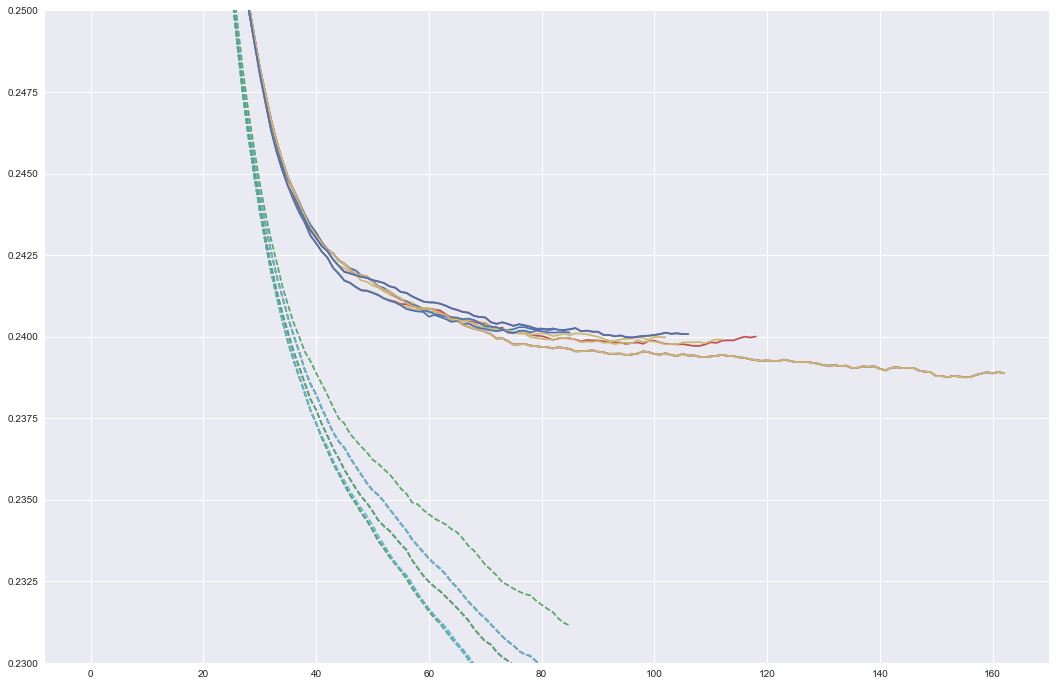

In [40]:
plt.figure(figsize=(18, 12))
plt.ylim((0.23, 0.25))
for i in range(num_searches):
    plt.plot(h['boost_round'][h.search_id == i], h['val-logloss'][h.search_id == i])
    plt.plot(h['boost_round'][h.search_id == i], h['train-logloss'][h.search_id == i], '--')
plt.show()

In [46]:
p.sort_values(by='last_val-logloss')

,boost_rounds,booster,colsample_bytree,eval_metric,last_val-logloss,learning_rate,max_depth,min_child_weight,objective,search_id,subsample,tree_method
0,163,gbtree,0.9,logloss,0.238877,0.1,8,100,reg:logistic,0,0.7,hist
7,163,gbtree,0.9,logloss,0.238877,0.1,8,100,reg:logistic,7,0.7,hist
8,163,gbtree,0.9,logloss,0.238877,0.1,8,100,reg:logistic,8,0.7,hist
5,113,gbtree,0.9,logloss,0.239910,0.1,12,100,reg:logistic,5,0.7,hist
2,103,gbtree,0.9,logloss,0.239980,0.1,13,100,reg:logistic,2,0.7,hist
1,119,gbtree,0.9,logloss,0.240002,0.1,15,100,reg:logistic,1,0.7,hist
4,107,gbtree,0.9,logloss,0.240080,0.1,9,100,reg:logistic,4,0.7,hist
9,107,gbtree,0.9,logloss,0.240080,0.1,9,100,reg:logistic,9,0.7,hist
6,86,gbtree,0.9,logloss,0.240121,0.1,7,100,reg:logistic,6,0.7,hist
3,83,gbtree,0.9,logloss,0.240216,0.1,14,100,reg:logistic,3,0.7,hist
